In [1]:
import numpy as np
import os
import util as u
import MRI_layers_MK1 as mri
import matplotlib.pyplot as plt
import pickle
from PIL import Image, ImageEnhance, ImageOps
from matplotlib import cm

In [2]:
base = "/Users/nathanielnethercott/Desktop/School/2021/Pickled_Sample/"
fpaths = [os.path.join(base,p) for p in os.listdir(base)]

In [3]:
#potential utility function 
def preprocess(im_array, cfactor=8):
    """
    assume data isn't normalized 
    we convert to grayscale 
    we constrast 
    """
    pil_im = Image.fromarray(im_array)
    pil_im = ImageOps.grayscale(pil_im)
    
    #enhancer 
    enhancer = ImageEnhance.Contrast(pil_im)
    im = enhancer.enhance(cfactor)
    
    return np.array(im)/255

def _preprocess(im_array, cfactor=8):
    """
    assume data isn't normalized 
    we convert to grayscale 
    we constrast 
    """
    pil_im = Image.fromarray(np.uint8(cm.gray(im_array)*255))
    pil_im = ImageOps.grayscale(pil_im)
    
    #enhancer 
    enhancer = ImageEnhance.Contrast(pil_im)
    im = enhancer.enhance(cfactor)
    
    return np.array(im)/255
    

In [4]:
#define some large scale function, should i make classes so we can access iterate information and stuff?
#maybe come up with a dynamic way of changing functionals?
class contour():
    def __init__(self, surf0, functional):
        #functional is a callable taking in a surface and image and returning a surface
        self.functional = functional
        
        #take in a nparray for initial surface 
        self.s0 = surf0
        self.s = surf0
        self.dim = surf0.shape
    
    def level_set_iter(self, surface, image, dt=0.0001):
        d = lambda x,y: (x**2 + y**2)**0.5
        sy, sx = np.gradient(surface, np.linspace(-1,1, self.dim[0]), np.linspace(-1,1, self.dim[1]))

        return surface - self.functional(surface, image)*d(sx,sy)*dt
    
    def iterate(self, image, dt=0.0001, numiters=1500):
        if image.shape==self.dim:
            for i in range(numiters):
                self.s = self.level_set_iter(self.s, image, dt)
                
        else:
            print('reference image must be same dimension as surface')
        
    def set_surf(self, surface):
        #use this if the iterations get messed up and we need to reset
        if surface.shape == self.dim:
            self.s = surface
        else:
            print('we require surface array to be consistent with initialized contour')
     
    #consider moving this function to a utility file 
    def positive_indeces(surface, geq=True):
        if geq:
            return list(zip(*np.where(surface>=0)))
        else:
            return list(zip(*np.where(surface>0)))
        
    def converged2mask(surf):
        mask = np.zeros((surf.shape[0], surf.shape[1]))
        positive_indeces = list(zip(*np.where(surf>=0)))
        for index in positive_indeces:
            mask[index] = 1.0
            
        return mask 

    def intensity(self, image, io=True, steps=4): 
        #gonna do the outwards pointing normal method?
        m = contour.converged2mask(self.s)
        
        #inwards pointing 
        gy,gx = np.gradient(m)
        
        #normalize and flip outwards
        nx = -gx/(np.sqrt(gx**2+gy**2)+ 0.000001)
        ny = -gy/(np.sqrt(gx**2+gy**2)+ 0.000001)
        n = np.sqrt(nx**2+ny**2)
        
        #now walk along the contour in the outwards direction...
        perimeter = contour.positive_indeces(n, geq=False)
        interior = contour.positive_indeces(self.s, geq=True)
        
        i_out = 0
        #lets walk a few steps in the outwards normal direction
        for index in perimeter:
            for i in range(steps):
                normal = np.array(nx[index], ny[index])
                new_index = index + (i+1)*normal
                new_index = (int(new_index[0]), int(new_index[1]))
                
                #update intensity, Note: may be a mistake in the ordering of coordinates...
                i_out+=image[new_index]/(len(perimeter)*steps)
                
        
        #now do the inside
        i_in = 0
        for index in interior:
            i_in += image[index]/len(interior)
        
        return i_in, i_out
        
        

def functional(surface, image):
    F1 = u.mean_curvature(surface)
    F2 = (image-1.0)**2 - (image - 0)**2
    return 0.001*F1 + 0.11*F2

c = contour(u.parabloid((100,100), xrad=0.6, yrad=0.6, left=0.2, top=0.4), functional)

In [9]:
#okay now for a larger scale thing 
#NOTE: this straightup only works with the data set we're given and i'm only making this so it's "nicely wrapped up"

#come up with a name later 
class sim():
    def __init__(self, scans, mask0, iters = 3000, dt=0.001):
        #assume we know which scans contain the lesion (i.e. a start and end index)
        #--> contours array of known length 
        self.contours = []
        self.ref = mask0
        
        #declare scans 
        self.scans = scans
        
        #set iteration params
        self.iters=iters
        self.dt = dt
        
        #generate initial surface 
        self.converge0(num = iters)
        
        
    def set_iters(self, iters):
        self.iters = iters
        
    def set_dt(self, dt):
        self.dt = dt
    
    #for right now lets assume we're given a mask with white inside, black outside and which denotes the lesion
    #we need to convert this to an initial surface 
    def converge0(self, num):
        #use mask0
        #define a custom functional for segmentation like we've seen already
        def functional(surface, image):
            F1 = u.mean_curvature(surface)
            F2 = (image-1.0)**2 - (image - 0)**2
            return 0.001*F1 + 0.11*F2
        
        c = contour(u.parabloid(self.ref.shape, xrad=0.7, yrad=0.7), functional)
        
        c.iterate(self.ref, numiters=7000, dt=0.001)
        
        #append the converged contour 
        self.contours.append(c)
        
    def show(self, index = 0, contour = False):
        plt.figure(figsize=(6,6))
        if contour:
            if (index)<= len(self.contours)-1:
                plt.imshow(self.scans[index])
                plt.contour(self.contours[index].s, [0], colors='red')
        else:
            plt.imshow(self.scans[index])

    def _next(self, functional):
        prev_index = len(self.contours)-1
        c = contour(self.contours[prev_index].s, functional)
        
        #now converge 
        c.iterate(self.scans[prev_index+1], numiters=self.iters, dt=self.dt)
        
        #append 
        self.contours.append(c)
        
        pass
    
    def next_(self):
        #logic for smart functionals goes here 
        #call self._next(functional)
        pass
    
    def clear(self):
        #remove num most recent contours 
        for i in range(len(self.contours)-1):
            self.contours.pop(len(self.contours)-1-i)
            
    def run(self, num):
        """
        exexcute consecutive _next methods 
        """
        pass
            

In [22]:
test = pickle.load(open(fpaths[1], 'rb'))

t1 = test[1]
t2 = test[2]

#only interested in scans with lesions
_masks = [t2[:,:,i] for i in mri._find_layers(t2)]
_scans = [t1[:,:,i] for i in mri._find_layers(t2)]

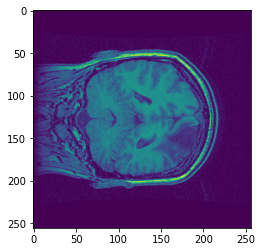

In [23]:
#find good params for reducing image size 
plt.imshow(_scans[12])
#plt.contour(_masks[12][85:165, 130:210])

#85:165, 130:210
#120:190, 130:210

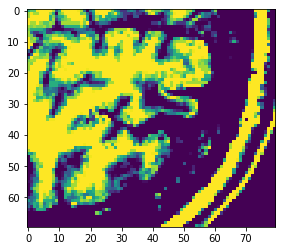

In [24]:
#downscale everything with knowledge of where the initial lesion is 
_masks_ = [mask[120:190, 130:210]/255 for mask in _masks]
_scans_ = [_preprocess(scan[120:190, 130:210]/255, cfactor=15) for scan in _scans]

#lets try pretending like the first scan is one halfway through 
ref = 1
_masks_ = _masks_[ref:]
_scans_ = _scans_[ref:]
plt.imshow(_scans_[0])

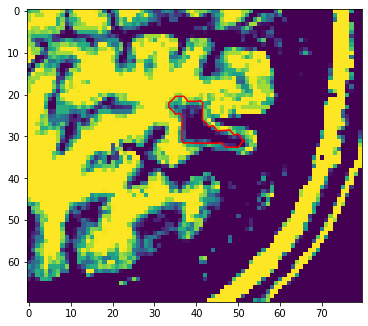

In [25]:
t = sim(_scans_, _masks_[0], iters=7000, dt=0.001)
t.show(0, contour=True)

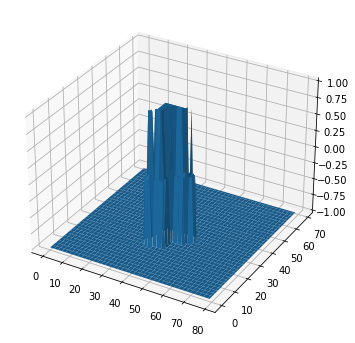

In [26]:
def surf2simple(surface, threshold = 0.05):
    
    #two step process
    #step 1
    s = -1*np.ones(surface.shape)
    positive_indeces = list(zip(*np.where(surface>0)))
                            
    for index in positive_indeces:
        s[index] = 1
    
    #step 2
    ny, nx = np.gradient(s)
    n = ny**2+nx**2
    zero_indeces = list(zip(*np.where(n>0)))
    
    for index in zero_indeces:
        s[index] = 0
    
    return s 

u.showsurf(surf2simple(t.contours[0].s))

In [27]:
#lets try this 
t.contours[0].s = surf2simple(t.contours[0].s)

In [31]:
def f(surface, image):
    i_in, i_out = t.contours[0].intensity(t.scans[0], steps=2)      
    #now use the segmentation functional we've been messing around with 
    F1 = u.mean_curvature(surface)
    F2 = (image-i_in)**2 - (image - i_out)**2
    
    #consider the area term
    area = lambda arr: len(contour.positive_indeces(arr, geq=False))
    a0 = area(_masks_[1])
    
    F3 = 2*(area(surface) - 1.05*a0)
    
    return 0.0001*F1 + 0.05*F2 + 0.03*F3
 

t.clear()
t.set_iters(5000)
t.set_dt(0.0005)

t._next(f)

<ipython-input-34-caef921a92cd>:4: UserWarning: No contour levels were found within the data range.
  plt.contour(_masks_[1], [0], colors='magenta')


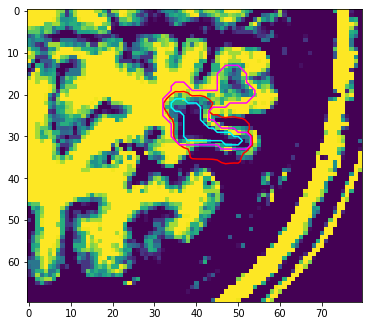

In [34]:
plt.figure(figsize=(6,6))
plt.contour(t.contours[0].s, [0], colors='cyan')
plt.contour(t.contours[1].s, [0], colors='red')
plt.contour(_masks_[1], [0], colors='magenta')
plt.imshow(t.scans[1])

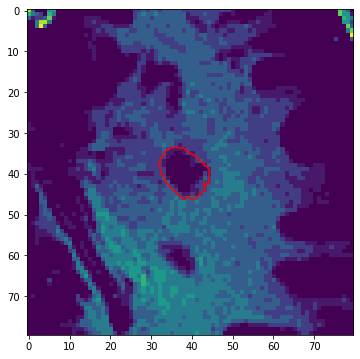

In [61]:
t.show(1, contour=True)

In [60]:
t.contours[0].intensity(t.scans[0], steps=2) 

(0.058019105077928596, 0.12739938080495342)

In [ ]:
"""
- multiply area term by something bigger to account for pixelated values (?)
- add regression stuff on the saved areas to guesstimate the next one 
- save intensity values so we can use in segmentation functional 
- eventually change the _next method to automatically come up with the functional 
"""